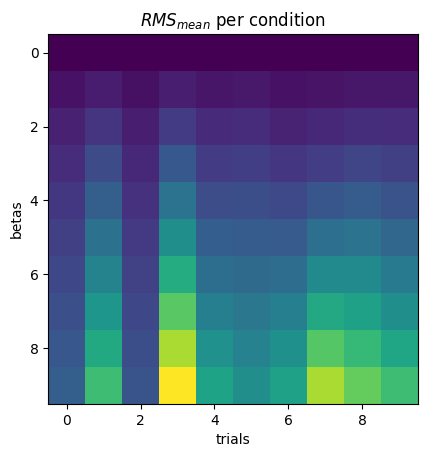

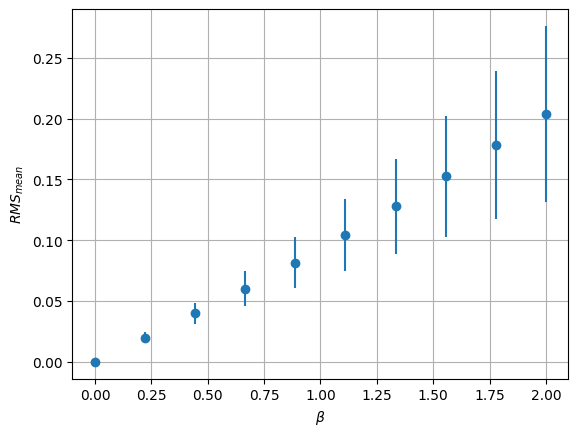

In [57]:
%reset -f 
import numpy as np
import itertools
import matplotlib.pyplot as plt


def H(states, couplings, field=None):
    if field is None:
        field = np.zeros(states.shape[1])
    E_states = 0.5 * np.sum(states * (couplings @ states.T).T, axis=1) + states @ field
    return E_states

def make_symmetric(matrix):
    return np.triu(matrix, 1) + np.triu(matrix, 1).T

def get_couplings(J0, J, n):
    mean = J0 / n
    std = J / np.sqrt(n)
    # randn samples from normal distribution
    return make_symmetric(mean + std * np.random.randn(n, n))

def RMSE(vec1, vec2):
    vec1 = np.array(vec1) if isinstance(vec1, list) else vec1
    vec2 = np.array(vec2) if isinstance(vec2, list) else vec2
    assert len(vec1.shape) == 1 and len(vec2.shape) == 1, "Ensure inputs are 1-D"
    assert np.array_equal(vec1.shape, vec2.shape), "Input vectors must have same length"

    return np.sqrt(np.mean((vec1 - vec2) ** 2))

def exact(n_spins:int, couplings:np.ndarray, field:np.ndarray, beta:int):
    # Get all random states
    spin_states = np.array(list(itertools.product([-1 ,1], repeat=n_spins)))
    spin_energies = H(spin_states, couplings, field)
    spin_energies = np.exp(-beta * spin_energies)
    # Get energies and derive probablity
    Z = np.sum(spin_energies)
    spin_probs = spin_energies / Z
    assert np.isclose(np.sum(spin_probs), 1), "Spin state probablities should sum up to 1"
    # Returns spin expectations
    spin_expts = spin_states.T @ spin_probs
    return spin_expts

def mf_approx(n_spins:int, couplings:np.ndarray, field:np.ndarray, mf_convergence_threshold=1e-13):
    spin_means = np.random.choice([-1, 1], n_spins) # start with random vector 
    indexes = np.array(range(spin_means.size))
    max_diff_spin = 1e10
    while max_diff_spin > mf_convergence_threshold:
        old_spin_means = np.copy(spin_means)
        for i in indexes:
            null_inxs = np.concatenate([indexes[:i], indexes[i+1:] ])
            interaction = np.dot(spin_means[null_inxs], couplings[i, null_inxs])
            spin_means[i] =  np.tanh(interaction + field[i])
        max_diff_spin = np.max(np.abs(old_spin_means - spin_means))
    return spin_means

def main():
    # Params
    n_spins = 10
    n_betas = 10
    betas = np.linspace(0, 2, n_betas)
    J0 = 0  
    J = 0.5
    J_field = 0.1
    n_trials = 10
    

    # Init couplings and random field
    couplings = get_couplings(J0, J, n_spins) # shape=(combination, spi
    fields = np.random.randn(n_trials, n_spins) * J_field 

    # Compute RMS error in mean
    RMSE_mean_mf = np.empty((n_betas, n_trials))
    # add correlation
    for row, beta in enumerate(betas):
        for col in range(n_trials):
            # Same field is used within trial
            # Different field is used between trials
            spin_expc_mf = mf_approx(n_spins, couplings, fields[col, :])
            spin_expc_exact = exact(n_spins, couplings, fields[col, :], beta) 
            RMSE_mean_mf[row, col] = RMSE(spin_expc_exact, spin_expc_mf)
    
    mean_RMSEmean_for_beta = np.mean(RMSE_mean_mf, axis=1)
    std_RMSEmean_for_beta = np.std(RMSE_mean_mf, axis=1)

    plt.imshow(RMSE_mean_mf)
    plt.xlabel('trials')
    plt.ylabel('betas')
    plt.title(r'$RMS_{mean}$ per condition')

    fig, ax = plt.subplots()
    ax.errorbar(betas, mean_RMSEmean_for_beta, yerr=std_RMSEmean_for_beta, fmt='o')
    ax.grid(True)
    ax.set_xlabel(r'$\beta$')
    ax.set_ylabel(r'$RMS_{mean}$')
    
main()